In [1]:
import numpy as np
from point_history import getmes
import pickle
import datetime
from get_point_map import get
from get_point_history import pget
from netCDF4 import Dataset
import pandas as pd
from ipywidgets import interact
import matplotlib.pyplot as plt

In [2]:
import scipy.io

In [3]:
import folium

In [4]:
import itertools

In [5]:
from pandas.compat import u

In [6]:
%matplotlib notebook

In [7]:
SAVEPATH='tmp/'

In [8]:
path='/mnt/web/brey/hincast/'

In [9]:
SAVEPATH='tmp/'#/mnt/pandora/Users_Critech/Thomas/HYFLUX/'

In [10]:
basename='med'

In [11]:
t1='20131201.00'

In [12]:
t2='20161208.00'

In [13]:
sdate=datetime.datetime.strptime(t1,'%Y%m%d.%H')

In [14]:
edate=datetime.datetime.strptime(t2,'%Y%m%d.%H')

In [15]:
path0=path+'{}/'.format(t1)

In [16]:
with open(path0+basename+'.pkl', 'r') as f:
    ptr=pickle.load(f)

In [17]:
iloc=1630 # CHANGE THIS FOR ANALYSIS OF ANOTHER OBS POINT

In [18]:
t,s,plat,plon,bname,bid = getmes(sdate,edate,iloc) # measured data
dic0={'t_gauge':t, 'sh':[a for [a,b,c] in s], 'tide':[b for [a,b,c] in s], 'ss':[c for [a,b,c] in s]}
data0=pd.DataFrame(dic0)
data0=data0.set_index('t_gauge')


In [19]:
tcw,cw,mlat,mlon,jc,ic=get(t1,t2,path,basename,plat,plon) # map interpolated data
dic1={'t_map':tcw, 's_map':cw}
data1=pd.DataFrame.from_dict(dic1)
data1=data1.set_index('t_map')
data=data0.join(data1, how='outer')

In [20]:
hcw,hw,hlat,hlon=pget(t1,t2,path,basename,ptr[iloc]) # obs point 1 min sampling 
dic2={'t_his':hcw, 's_his':hw}
data2=pd.DataFrame.from_dict(dic2)
data2=data2.set_index('t_his')
data=data.join(data2, how='outer')

In [21]:
#check that the 'returned' iDs are the same as the read ones
np.int(bid) == iloc

True

In [22]:
data.head()

,sh,ss,tide,s_map,s_his
2013-12-01 00:00:00,NaN,NaN,NaN,0.005537,0.005537
2013-12-01 00:01:00,NaN,NaN,NaN,NaN,0.005778
2013-12-01 00:02:00,NaN,NaN,NaN,NaN,0.006035
2013-12-01 00:03:00,NaN,NaN,NaN,NaN,0.006353
2013-12-01 00:04:00,NaN,NaN,NaN,NaN,0.006755


In [23]:
if data['sh'].dropna().sum() is 0:
    print 'no obs, replacing with zeros'
    data[['sh','ss','tide']]=0.0

In [24]:
data.head()

,sh,ss,tide,s_map,s_his
2013-12-01 00:00:00,NaN,NaN,NaN,0.005537,0.005537
2013-12-01 00:01:00,NaN,NaN,NaN,NaN,0.005778
2013-12-01 00:02:00,NaN,NaN,NaN,NaN,0.006035
2013-12-01 00:03:00,NaN,NaN,NaN,NaN,0.006353
2013-12-01 00:04:00,NaN,NaN,NaN,NaN,0.006755


### read grid 

In [25]:
d=Dataset(path0+'trim-'+basename+'.nc')

In [26]:
xg=d['XCOR'][:]
yg=d['YCOR'][:]

In [27]:
xz=d['XZ'][:]
yz=d['YZ'][:]

In [31]:
mapa = folium.Map(location=[plat, plon], zoom_start=12)

In [32]:
folium.Marker([plat,plon], popup=bname).add_to(mapa)

In [33]:
plat,plon, ic, jc

('36.830', '-2.478', 295, 180)

In [34]:
folium.CircleMarker([yz[ic,jc],xz[ic,jc]], popup='{},{}/{},{}'.format(mlat,mlon,jc,ic)).add_to(mapa)

In [35]:
folium.CircleMarker([mlat,mlon], popup='{},{}'.format(mlat,mlon),fill_color='blue').add_to(mapa)

In [36]:
mlat,mlon

(40.507649000000001, 14.158061485000001)

In [37]:
folium.CircleMarker([hlat,hlon], popup='{},{}'.format(hlat,hlon),fill_color='green').add_to(mapa)

In [38]:
%%skip
folium.LatLngPopup().add_to(mapa) # click to show lat lon

In [39]:
a=np.arange(-5,5)
b=np.arange(-5,5)
glist=[]
for r in itertools.product(a,b): glist.append((r[0],r[1]))
#glist

In [40]:
for k,l in glist:
    try:
        m1=ic+k
        m2=jc+l
        xgrid=zip(yg[m1,m2-5:m2+5],xg[m1,m2-5:m2+5])
        ygrid=zip(yg[m1-5:m1+5,m2],xg[m1-5:m1+5,m2])
        folium.PolyLine(xgrid,weight=1, color='black').add_to(mapa)
        folium.PolyLine(ygrid,weight=1, color='black').add_to(mapa)
        folium.CircleMarker([yg[m1,m2],xg[m1,m2]], popup='{},{}'.format(m1,m2), radius=50).add_to(mapa)
        folium.CircleMarker([yz[m1,m2],xz[m1,m2]], popup='{},{}'.format(m1,m2), radius=50, fill_color='red').add_to(mapa)
    except Exception as e:
        print e
        pass

In [41]:
mapa

<IPython.core.display.Javascript object>


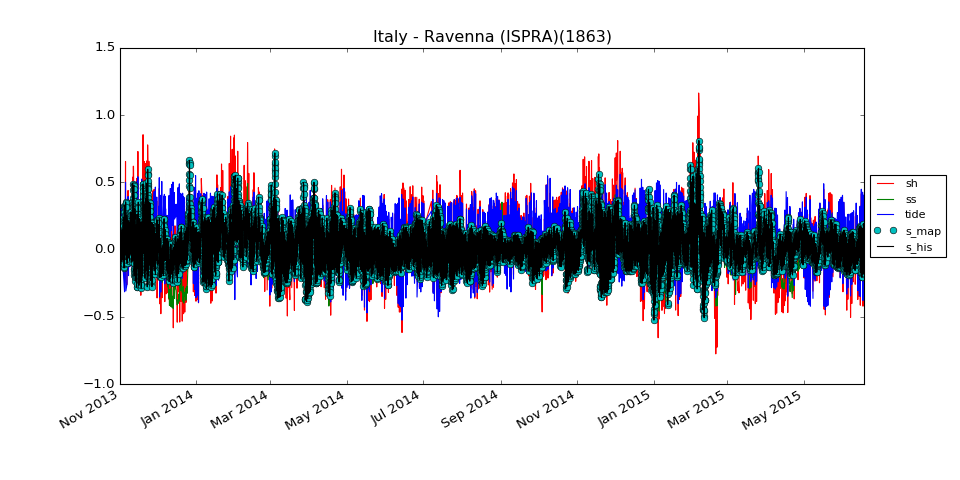

In [67]:
ax=data[['sh','ss','tide']].dropna().apply(pd.to_numeric).plot(figsize=(12,6),style=['r-','g-','b-'])
data[['s_map','s_his']].dropna().apply(pd.to_numeric).plot(ax=ax, style=['co','k-'])
ax.legend(loc='center left', bbox_to_anchor=(1.,.5), prop={'size':10})
ax.set_title(bname+'('+bid+')')

<IPython.core.display.Javascript object>


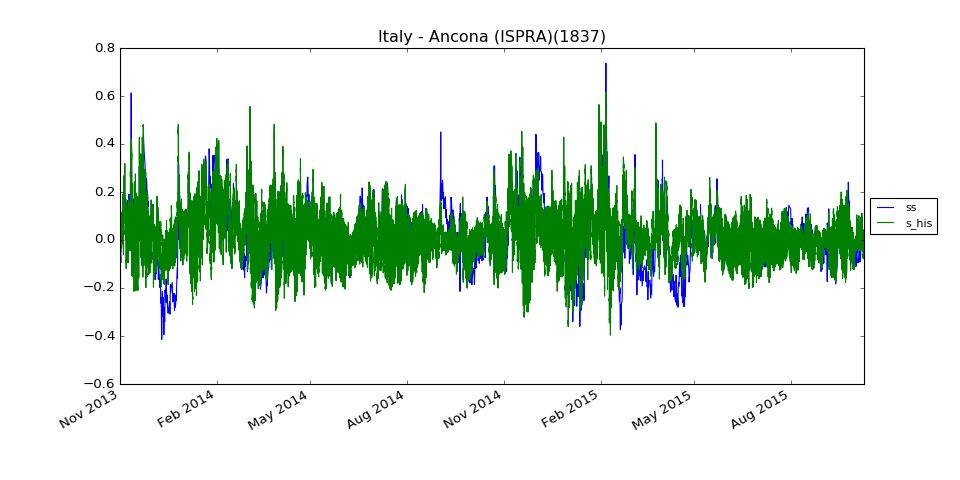

In [73]:
ax1=data['ss'].dropna().apply(pd.to_numeric).plot(figsize=(12,6),style=['b-'])
data['s_his'].dropna().apply(pd.to_numeric).plot(ax=ax1, style=['g-'])
ax1.legend(loc='center left', bbox_to_anchor=(1.,.5), prop={'size':10})
ax1.set_title(bname+'('+bid+')')

## check variance

In [ ]:
obs = data['ss'].dropna().apply(pd.to_numeric)

In [75]:
num = data['s_his'].dropna().apply(pd.to_numeric)

computer rolling mean every 60 points

In [76]:
ma = obs.rolling(60).mean()

In [77]:
mstd = obs.rolling(60).std() #standard deviation

<IPython.core.display.Javascript object>


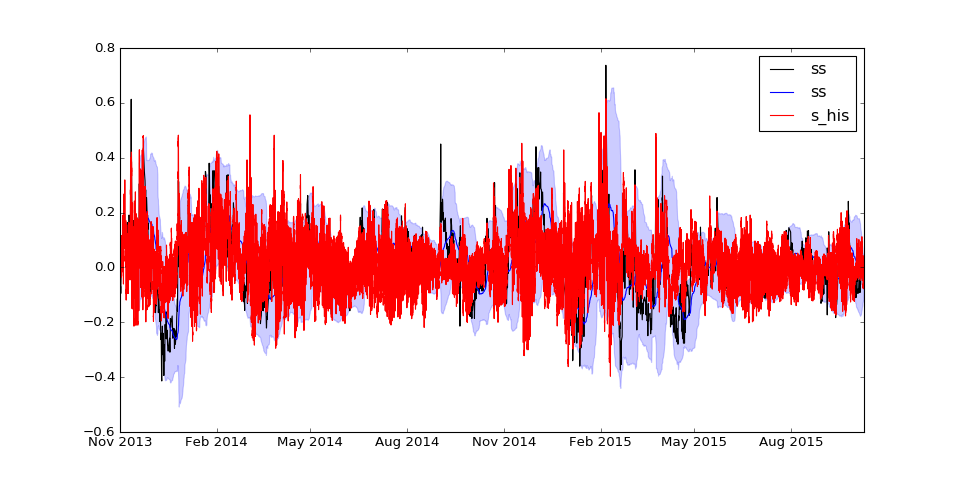

In [78]:
#plot them
plt.figure(figsize=(12,6))
plt.plot(obs.index, obs, 'k')
plt.plot(ma.index, ma, 'b')
plt.plot(num.index, num, 'r')
plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)
plt.legend(loc=0)

## Get All forecasting data

In [19]:
dt=(edate-sdate).total_seconds()
ndt=dt/(3600*12)
ndt=np.int(ndt)+1

In [20]:
combined=[] # store time and height
tstamp = [] # for use later

In [21]:
tot=[]

In [22]:
indx=pd.date_range(sdate, edate, freq='12H')

In [23]:
val=[]

In [24]:
for it in range(ndt):
    idate=sdate+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    path0=path+'{}/'.format(dstamp)
    filename=path0+'trih-'+basename+'.nc'
    d =  Dataset(filename)
    ha=d.variables['ZWL'][:,ptr[iloc]] # all values
    t=d.variables['time'][:]
    tw=[]
    for it in t:
        tw.append(idate+datetime.timedelta(seconds=np.int(it)))
    ttw=[(item-t[0])/60. for item in t]
    dic={'time':tw, 'numerical storm surge':ha, 'forecast_time':ttw}
    val.append(ha)
    data=pd.DataFrame.from_dict(dic)
    data=data.set_index('time')
    tot.append(data)

In [25]:
tota=pd.concat(tot,keys=indx)

In [26]:
tota.head()

forecast_time  numerical storm surge
           time                                                     
2013-12-01 2013-12-01 00:00:00            0.0               0.005537
           2013-12-01 00:01:00            1.0               0.005778
           2013-12-01 00:02:00            2.0               0.006035
           2013-12-01 00:03:00            3.0               0.006353
           2013-12-01 00:04:00            4.0               0.006755

In [27]:
dat=tota.drop('forecast_time',1)

In [28]:
dat.head()

numerical storm surge
           time                                      
2013-12-01 2013-12-01 00:00:00               0.005537
           2013-12-01 00:01:00               0.005778
           2013-12-01 00:02:00               0.006035
           2013-12-01 00:03:00               0.006353
           2013-12-01 00:04:00               0.006755

## plot all forecasts

In [ ]:
dat.unstack(level=0).plot(figsize=(12,6),legend=False)

In [ ]:
## save the data
dat.to_csv(SAVEPATH+bname+'time_ref.csv', header=None)

## Analysis 

In [355]:
mindx=dat.xs('2013-12-21 00:00:00')

### average of 5 minutes 

In [356]:
mindx.rolling(5,center=True).mean()[::60][:10] # rolling mean ever 5 values, given every 60 indeces 

,numerical storm surge
time,
2013-12-21 00:00:00,NaN
2013-12-21 01:00:00,-0.020928
2013-12-21 02:00:00,-0.041718
2013-12-21 03:00:00,-0.067237
2013-12-21 04:00:00,-0.090309
2013-12-21 05:00:00,-0.120206
2013-12-21 06:00:00,-0.095912
2013-12-21 07:00:00,-0.080744
2013-12-21 08:00:00,-0.096900


In [357]:
#Test the above
ar=[]
for i in range(0,mindx.shape[0],60):
    ar.append(np.mean(mindx[i-2:i+3]))
ar[:10]    

[numerical storm surge   NaN
 dtype: float32, numerical storm surge   -0.020928
 dtype: float32, numerical storm surge   -0.041718
 dtype: float32, numerical storm surge   -0.067237
 dtype: float32, numerical storm surge   -0.090309
 dtype: float32, numerical storm surge   -0.120206
 dtype: float32, numerical storm surge   -0.095912
 dtype: float32, numerical storm surge   -0.080744
 dtype: float32, numerical storm surge   -0.0969
 dtype: float32, numerical storm surge   -0.069816
 dtype: float32]

### maximum of hourly data

In [358]:
mindx.rolling(60,center=True).max()[::60][:10]


,numerical storm surge
time,
2013-12-21 00:00:00,NaN
2013-12-21 01:00:00,-0.020258
2013-12-21 02:00:00,-0.030580
2013-12-21 03:00:00,-0.029951
2013-12-21 04:00:00,-0.073899
2013-12-21 05:00:00,-0.096839
2013-12-21 06:00:00,-0.089474
2013-12-21 07:00:00,-0.080071
2013-12-21 08:00:00,-0.080003


In [359]:
# test
ar=[]
for i in range(0,mindx.shape[0],60):
    ar.append(np.max(mindx[i-30:i+31]))
ar[:10]    

[numerical storm surge   NaN
 dtype: float64, numerical storm surge   -0.020258
 dtype: float32, numerical storm surge   -0.029951
 dtype: float32, numerical storm surge   -0.029951
 dtype: float32, numerical storm surge   -0.073899
 dtype: float32, numerical storm surge   -0.09611
 dtype: float32, numerical storm surge   -0.089474
 dtype: float32, numerical storm surge   -0.080071
 dtype: float32, numerical storm surge   -0.080003
 dtype: float32, numerical storm surge   -0.061156
 dtype: float32]

## compute corellation between measured and computed

In [447]:
num.head()

2013-11-01 00:00:00    0.000000
2013-11-01 00:01:00    0.000005
2013-11-01 00:02:00    0.000018
2013-11-01 00:03:00    0.000039
2013-11-01 00:04:00    0.000065
Name: s_his, dtype: float64

In [450]:
obs.head()

s
time       offset          
2013-12-01 0       0.021667
           1       0.032000
           2       0.051400
           3       0.015400
           4       0.048800

In [ ]:
rnum=num.reindex(obs.index,method='pad')

In [ ]:
rnum.corr(obs) #total correlation

In [52]:
rnum.rolling(window=10, center=True).corr(obs).mean()

0.21227543554709399

<IPython.core.display.Javascript object>


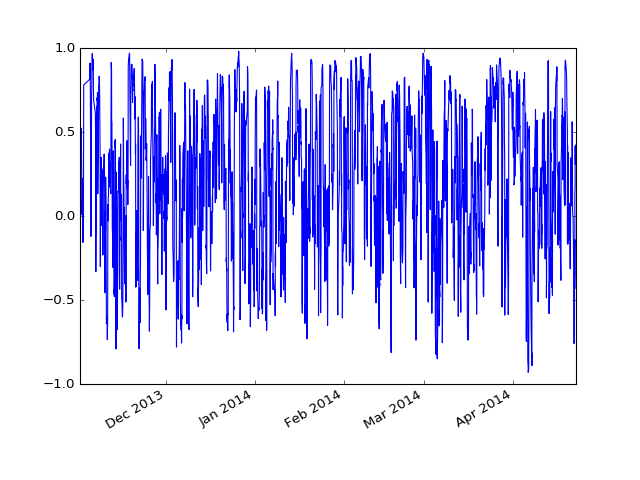

In [53]:
rnum.rolling(window=10, center=True).corr(obs).plot()

## replace index

In [29]:
tota.head()

forecast_time  numerical storm surge
           time                                                     
2013-12-01 2013-12-01 00:00:00            0.0               0.005537
           2013-12-01 00:01:00            1.0               0.005778
           2013-12-01 00:02:00            2.0               0.006035
           2013-12-01 00:03:00            3.0               0.006353
           2013-12-01 00:04:00            4.0               0.006755

In [30]:
#tota.index=tota.index.droplevel(1)

In [31]:
tota.drop('forecast_time',1, inplace=True)

In [32]:
#tota.reset_index(level=0, inplace=True)

In [33]:
#tota.set_index(['index','forecast_time'], inplace=True)

In [34]:
tota.head()

numerical storm surge
           time                                      
2013-12-01 2013-12-01 00:00:00               0.005537
           2013-12-01 00:01:00               0.005778
           2013-12-01 00:02:00               0.006035
           2013-12-01 00:03:00               0.006353
           2013-12-01 00:04:00               0.006755

In [35]:
tota.index.tolist()[:10]

[(Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:00:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:01:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:02:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:03:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:04:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:05:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:06:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:07:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:08:00')),
 (Timestamp('2013-12-01 00:00:00'), Timestamp('2013-12-01 00:09:00'))]

In [36]:
ht=np.array([np.arange(4321) for i in range(tota.index.levels[0].shape[0])]).ravel()

In [37]:
ht.shape

(7095082,)

In [38]:
len(tota.index.tolist())

7095082

In [39]:
index0=[(a, c) for (a,b),c in zip(tota.index.tolist(),ht)]

In [40]:
tota.index=pd.MultiIndex.from_tuples(index0,names=tota.index.names)

In [41]:
tota.head()

numerical storm surge
           time                       
2013-12-01 0                  0.005537
           1                  0.005778
           2                  0.006035
           3                  0.006353
           4                  0.006755

In [42]:
tota.unstack(level=0).head()

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                 0.005537           -0.043900           -0.138706   
1                 0.005778           -0.043640           -0.137605   
2                 0.006035           -0.043522           -0.136266   
3                 0.006353           -0.043555           -0.134740   
4                 0.006755           -0.043754           -0.133100   

                                                                  \
     2013-12-02 12:00:00 2013-12-03 00:00:00 2013-12-03 12:00:00   
time                                                               
0              -0.030800           -0.042397           -0.076252   
1              -0.031064           -0.042507           -0.078262   
2              -0.031425           -0.042363           -0.080190   
3              -0.031856           -0.041957           -0.081935   
4              -0.032323           -0.041293           -0.083412   

                                                                  \
     2013-12-04 00:00:00 2013-12-04 12:00:00 2013-12-05 00:00:00   
time                                                               
0              -0.052062           -0.084320           -0.060959   
1              -0.053670           -0.085714           -0.061719   
2              -0.055411           -0.086946           -0.062580   
3              -0.057179           -0.088011           -0.063537   
4              -0.058899           -0.088907           -0.064574   

                                 ...                              \
     2013-12-05 12:00:00         ...         2016-02-25 00:00:00   
time                             ...                               
0              -0.063311         ...                   -0.040074   
1              -0.063414         ...                   -0.037908   
2              -0.063785         ...                   -0.035779   
3              -0.064413         ...                   -0.034152   
4              -0.065290         ...                   -0.033372   

                                                                  \
     2016-02-25 12:00:00 2016-02-26 00:00:00 2016-02-26 12:00:00   
time                                                               
0              -0.028216           -0.059162           -0.067401   
1              -0.026527           -0.060904           -0.068685   
2              -0.024167           -0.062185           -0.069930   
3              -0.021478           -0.062849           -0.070757   
4              -0.018910           -0.062968           -0.070920   

                                                                  \
     2016-02-27 00:00:00 2016-02-27 12:00:00 2016-02-28 00:00:00   
time                                                               
0               0.045699            0.068263            0.128071   
1               0.044757            0.070782            0.127292   
2               0.043291            0.072857            0.126263   
3               0.041577            0.074527            0.124878   
4               0.039935            0.075983            0.123143   

                                                                  
     2016-02-28 12:00:00 2016-02-29 00:00:00 2016-02-29 12:00:00  
time                                                              
0               0.047023           -0.052654           -0.042287  
1               0.047575           -0.053261           -0.041034  
2               0.048533           -0.053368           -0.039823  
3               0.049734           -0.053123           -0.038746  
4               0.051019           -0.052722           -0.037984  

[5 rows x 1642 columns]

### rolling average for all

In [43]:
s=tota.unstack(level=0)

In [44]:
s.head()

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                 0.005537           -0.043900           -0.138706   
1                 0.005778           -0.043640           -0.137605   
2                 0.006035           -0.043522           -0.136266   
3                 0.006353           -0.043555           -0.134740   
4                 0.006755           -0.043754           -0.133100   

                                                                  \
     2013-12-02 12:00:00 2013-12-03 00:00:00 2013-12-03 12:00:00   
time                                                               
0              -0.030800           -0.042397           -0.076252   
1              -0.031064           -0.042507           -0.078262   
2              -0.031425           -0.042363           -0.080190   
3              -0.031856           -0.041957           -0.081935   
4              -0.032323           -0.041293           -0.083412   

                                                                  \
     2013-12-04 00:00:00 2013-12-04 12:00:00 2013-12-05 00:00:00   
time                                                               
0              -0.052062           -0.084320           -0.060959   
1              -0.053670           -0.085714           -0.061719   
2              -0.055411           -0.086946           -0.062580   
3              -0.057179           -0.088011           -0.063537   
4              -0.058899           -0.088907           -0.064574   

                                 ...                              \
     2013-12-05 12:00:00         ...         2016-02-25 00:00:00   
time                             ...                               
0              -0.063311         ...                   -0.040074   
1              -0.063414         ...                   -0.037908   
2              -0.063785         ...                   -0.035779   
3              -0.064413         ...                   -0.034152   
4              -0.065290         ...                   -0.033372   

                                                                  \
     2016-02-25 12:00:00 2016-02-26 00:00:00 2016-02-26 12:00:00   
time                                                               
0              -0.028216           -0.059162           -0.067401   
1              -0.026527           -0.060904           -0.068685   
2              -0.024167           -0.062185           -0.069930   
3              -0.021478           -0.062849           -0.070757   
4              -0.018910           -0.062968           -0.070920   

                                                                  \
     2016-02-27 00:00:00 2016-02-27 12:00:00 2016-02-28 00:00:00   
time                                                               
0               0.045699            0.068263            0.128071   
1               0.044757            0.070782            0.127292   
2               0.043291            0.072857            0.126263   
3               0.041577            0.074527            0.124878   
4               0.039935            0.075983            0.123143   

                                                                  
     2016-02-28 12:00:00 2016-02-29 00:00:00 2016-02-29 12:00:00  
time                                                              
0               0.047023           -0.052654           -0.042287  
1               0.047575           -0.053261           -0.041034  
2               0.048533           -0.053368           -0.039823  
3               0.049734           -0.053123           -0.038746  
4               0.051019           -0.052722           -0.037984  

[5 rows x 1642 columns]

In [373]:
s.rolling(60,center=True).max()[::60] # max within 1 hour centered on the hour

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                      NaN                 NaN                 NaN   
60               -0.081157            0.119435            0.078607   
120              -0.067438            0.133171            0.096184   
180              -0.050100            0.121900            0.119054   
240              -0.066086            0.099442            0.141245   
300              -0.026576            0.094809            0.148900   
360              -0.009115            0.065730            0.137231   
420               0.008983            0.041875            0.145802   
480               0.033048            0.027662            0.148121   
540               0.076296            0.035536            0.145294   
600               0.078510            0.021661            0.132598   
660               0.091865            0.026736            0.115289   
720               0.101002            0.058952            0.107076   
780               0.113162            0.081842            0.074860   
840               0.123368            0.090630            0.046774   
900               0.120825            0.108396            0.025141   
960               0.107501            0.134315           -0.020881   
1020              0.101842            0.143716           -0.055552   
1080              0.067301            0.135571           -0.115835   
1140              0.038945            0.144036           -0.155976   
1200              0.018463            0.144134           -0.173472   
1260             -0.002802            0.140966           -0.158901   
1320             -0.002039            0.121459           -0.127400   
1380              0.000618            0.104245           -0.109283   
1440              0.020534            0.111483           -0.074726   
1500              0.045734            0.081420           -0.043406   
1560              0.056563            0.059942           -0.035889   
1620              0.070622            0.030104           -0.030945   
1680              0.085326           -0.012378           -0.029928   
1740              0.099902           -0.062453           -0.005410   
...                    ...                 ...                 ...   
2580             -0.150068            0.045440           -0.152443   
2640             -0.158299            0.052547           -0.153291   
2700             -0.166737            0.057597           -0.132529   
2760             -0.157110            0.051181           -0.103380   
2820             -0.136752            0.036354           -0.085317   
2880             -0.115517            0.024639           -0.069834   
2940             -0.083203           -0.015477           -0.033400   
3000             -0.067492           -0.027391           -0.022716   
3060             -0.037941           -0.046502           -0.009813   
3120             -0.024546           -0.084280            0.010242   
3180             -0.007421           -0.113392            0.019325   
3240              0.028191           -0.135251            0.028259   
3300              0.045134           -0.151381            0.031863   
3360              0.057171           -0.159584            0.017944   
3420              0.062706           -0.143160            0.006164   
3480              0.062142           -0.113056            0.001335   
3540              0.049630           -0.098856           -0.036539   
3600              0.032893           -0.071123           -0.045799   
3660              0.006300           -0.025706           -0.058112   
3720             -0.018423           -0.018330           -0.085707   
3780             -0.037143           -0.000208           -0.104000   
3840             -0.069960            0.017989           -0.125418   
3900             -0.112943            0.020033           -0.124999   
3960           

### test the above values

In [374]:
testd=s.iloc[:,s.columns.get_level_values(1)=='2013-12-23 00:00:00']

In [375]:
testd.rolling(60,center=True).max()[::60][:10]

,numerical storm surge
,2013-12-23
time,
0,NaN
60,-0.067535
120,-0.070219
180,-0.073667
240,-0.066043
300,-0.046314
360,-0.041350
420,-0.036934


In [376]:
testd[90:150].max()

numerical storm surge  2013-12-23   -0.070219
dtype: float32

In [377]:
ar=[]
for i in range(0,testd.shape[0],60):
    ar.append(np.max(testd[i-30:i+30]))
ar[:10]   

[numerical storm surge  2013-12-23   NaN
 dtype: float64, numerical storm surge  2013-12-23   -0.067535
 dtype: float32, numerical storm surge  2013-12-23   -0.070219
 dtype: float32, numerical storm surge  2013-12-23   -0.073667
 dtype: float32, numerical storm surge  2013-12-23   -0.066043
 dtype: float32, numerical storm surge  2013-12-23   -0.046314
 dtype: float32, numerical storm surge  2013-12-23   -0.04135
 dtype: float32, numerical storm surge  2013-12-23   -0.036934
 dtype: float32, numerical storm surge  2013-12-23   -0.024604
 dtype: float32, numerical storm surge  2013-12-23   -0.001141
 dtype: float32]

In [ ]:
## save the data
s.to_csv(SAVEPATH+bname+'forecast.csv')

#### output for verif

In [351]:
av5=s.rolling(5,center=True, min_periods=3).mean()[::60][:25] # mean within 5 min for every hour centered

In [352]:
av5

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                 0.005783           -0.043688           -0.137526   
60                0.037880           -0.052716           -0.101242   
120               0.038775           -0.030917           -0.067542   
180               0.007631           -0.055568           -0.069785   
240              -0.007422           -0.083612           -0.093101   
300              -0.022547           -0.102237           -0.108110   
360              -0.005129           -0.082570           -0.101247   
420               0.021844           -0.083483           -0.062346   
480               0.021742           -0.091683           -0.033676   
540              -0.001055           -0.126607           -0.012547   
600              -0.039362           -0.138239           -0.035235   
660              -0.067753           -0.147076           -0.046070   
720              -0.044026           -0.138451           -0.030929   
780              -0.050242           -0.100337            0.013621   
840              -0.034589           -0.072211            0.024140   
900              -0.060488           -0.074161            0.033014   
960              -0.090637           -0.097774            0.004118   
1020             -0.113685           -0.108347            0.007060   
1080             -0.092192           -0.101507           -0.009957   
1140             -0.093221           -0.064059            0.023935   
1200             -0.097688           -0.032535            0.014289   
1260             -0.126811           -0.017026            0.010114   
1320             -0.138250           -0.039938           -0.005820   
1380             -0.148820           -0.046638           -0.020869   
1440             -0.147522           -0.027289           -0.034442   

                                                                  \
     2013-12-02 12:00:00 2013-12-03 00:00:00 2013-12-03 12:00:00   
time                                                               
0              -0.031097           -0.042422           -0.078235   
60              0.011251           -0.036996           -0.062146   
120             0.022980            0.001260           -0.039008   
180             0.031541            0.008638           -0.039235   
240             0.000242           -0.023205           -0.053350   
300             0.002367           -0.064539           -0.062366   
360            -0.015885           -0.066531           -0.088436   
420             0.024252           -0.066060           -0.056918   
480             0.014578           -0.063691           -0.028095   
540             0.012510           -0.040543           -0.015495   
600            -0.008460           -0.057212           -0.026363   
660            -0.027541           -0.081403           -0.041003   
720            -0.042166           -0.076277           -0.052297   
780            -0.036411           -0.063851           -0.058393   
840             0.000016           -0.037255           -0.039147   
900             0.008057           -0.033219           -0.015886   
960            -0.022609           -0.043429           -0.014250   
1020           -0.061065           -0.053843           -0.028151   
1080           -0.060433           -0.079343           -0.039732   
1140           -0.068611           -0.052773           -0.034825   
1200           -0.060536           -0.021559           -0.034437   
1260           -0.039141           -0.014881           -0.030384   
1320           -0.048433           -0.018947           -0.054169   
1380           -0.070681           -0.032779           -0.063419   
1440           -0.063051           -0.042348           -0.080540   

                                                                  \
     2013-12-04 00:00:00 2013-12-04 12:00:00 2013-12-05 00:00:00   
tim

In [353]:
av5.index=av5.index/60

In [354]:
av5

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                 0.005783           -0.043688           -0.137526   
1                 0.037880           -0.052716           -0.101242   
2                 0.038775           -0.030917           -0.067542   
3                 0.007631           -0.055568           -0.069785   
4                -0.007422           -0.083612           -0.093101   
5                -0.022547           -0.102237           -0.108110   
6                -0.005129           -0.082570           -0.101247   
7                 0.021844           -0.083483           -0.062346   
8                 0.021742           -0.091683           -0.033676   
9                -0.001055           -0.126607           -0.012547   
10               -0.039362           -0.138239           -0.035235   
11               -0.067753           -0.147076           -0.046070   
12               -0.044026           -0.138451           -0.030929   
13               -0.050242           -0.100337            0.013621   
14               -0.034589           -0.072211            0.024140   
15               -0.060488           -0.074161            0.033014   
16               -0.090637           -0.097774            0.004118   
17               -0.113685           -0.108347            0.007060   
18               -0.092192           -0.101507           -0.009957   
19               -0.093221           -0.064059            0.023935   
20               -0.097688           -0.032535            0.014289   
21               -0.126811           -0.017026            0.010114   
22               -0.138250           -0.039938           -0.005820   
23               -0.148820           -0.046638           -0.020869   
24               -0.147522           -0.027289           -0.034442   

                                                                  \
     2013-12-02 12:00:00 2013-12-03 00:00:00 2013-12-03 12:00:00   
time                                                               
0              -0.031097           -0.042422           -0.078235   
1               0.011251           -0.036996           -0.062146   
2               0.022980            0.001260           -0.039008   
3               0.031541            0.008638           -0.039235   
4               0.000242           -0.023205           -0.053350   
5               0.002367           -0.064539           -0.062366   
6              -0.015885           -0.066531           -0.088436   
7               0.024252           -0.066060           -0.056918   
8               0.014578           -0.063691           -0.028095   
9               0.012510           -0.040543           -0.015495   
10             -0.008460           -0.057212           -0.026363   
11             -0.027541           -0.081403           -0.041003   
12             -0.042166           -0.076277           -0.052297   
13             -0.036411           -0.063851           -0.058393   
14              0.000016           -0.037255           -0.039147   
15              0.008057           -0.033219           -0.015886   
16             -0.022609           -0.043429           -0.014250   
17             -0.061065           -0.053843           -0.028151   
18             -0.060433           -0.079343           -0.039732   
19             -0.068611           -0.052773           -0.034825   
20             -0.060536           -0.021559           -0.034437   
21             -0.039141           -0.014881           -0.030384   
22             -0.048433           -0.018947           -0.054169   
23             -0.070681           -0.032779           -0.063419   
24             -0.063051           -0.042348           -0.080540   

                                                                  \
     2013-12-04 00:00:00 2013-12-04 12:00:00 2013-12-05 00:00:00   
tim

In [355]:
sav5=av5.unstack()

In [356]:
sav5.index=sav5.index.droplevel(level=0)

In [357]:
sav5.head()

            time
2013-12-01  0       0.005783
            1       0.037880
            2       0.038775
            3       0.007631
            4      -0.007422
dtype: float64

In [223]:
s24=av5.iloc[:,::2].unstack()

In [224]:
s24.index=s24.index.droplevel(level=0)

In [225]:
s24.head()

            time
2013-12-01  0       0.005783
            1       0.037880
            2       0.038775
            3       0.007631
            4      -0.007422
dtype: float64

#### read cleaned obs

In [393]:
#obs=pd.read_csv('/mnt/pandora/Users_Critech/brey/Obs_Ancona_hourly_5min_aver.txt',delimiter='\t', date_parser=True, header=None, names=['time','s'])

In [317]:
mat=scipy.io.loadmat('/mnt/pandora/Users_Critech/Brey/Almei.mat')

In [318]:
obs=pd.DataFrame({'time':mat['times'].flatten(),'s':mat['ss_Almei'].flatten(), 'offset':mat['offset'].flatten()})

In [319]:
obs.head()

,offset,s,time
0,0,0.100667,201312010000
1,1,0.057200,201312010100
2,2,0.058800,201312010200
3,3,0.061600,201312010300
4,4,0.057600,201312010400


In [320]:
obs['time']=pd.to_datetime(obs['time'].str[:-4])

In [321]:
obs[:26]

,offset,s,time
0,0,0.100667,2013-12-01
1,1,0.057200,2013-12-01
2,2,0.058800,2013-12-01
3,3,0.061600,2013-12-01
4,4,0.057600,2013-12-01
5,5,0.086400,2013-12-01
6,6,0.048000,2013-12-01
7,7,0.026000,2013-12-01
8,8,0.035500,2013-12-01
9,9,0.006400,2013-12-01


In [322]:
#take out the duplicate 24h value
#obs=obs.drop(24,level=1)

In [323]:
#take out the duplicate 24h value
obs=obs[obs.offset != 24]

In [324]:
obs[:26]

,offset,s,time
0,0,0.100667,2013-12-01
1,1,0.057200,2013-12-01
2,2,0.058800,2013-12-01
3,3,0.061600,2013-12-01
4,4,0.057600,2013-12-01
5,5,0.086400,2013-12-01
6,6,0.048000,2013-12-01
7,7,0.026000,2013-12-01
8,8,0.035500,2013-12-01
9,9,0.006400,2013-12-01


In [325]:
#dublicate for x.12 analysis
obs12s=obs['s'][12:]
obs12times=obs['time']+datetime.timedelta(hours=12)
obs12offset=obs['offset']

In [326]:
obs12s.values.shape, obs12times.values[:-12].shape, obs12offset.values[:-12].shape


((20436,), (20436,), (20436,))

In [327]:
obs12=pd.DataFrame({'time':obs12times.values[:-12],'s':obs12s.values,'offset':obs12offset.values[:-12]})

## add the 24 forecast for the 00

In [328]:
#copy the 0 values
ext=obs[::24].copy()

In [329]:
#change the offset
ext.offset=24

In [330]:
#change time to the previous day
ext.time=ext.time-datetime.timedelta(days=1)

In [331]:
ext=ext.drop(0) # drop the first value which is not valid

In [332]:
ext=ext.set_index(['time','offset'])

In [333]:
ext.head()

,,s
time,offset,
2013-12-01,24,0.0186
2013-12-02,24,0.1156
2013-12-03,24,-0.0260
2013-12-04,24,-0.0550
2013-12-05,24,-0.0360


In [334]:
obs=obs.set_index(['time','offset'])

In [335]:
obs_ex=pd.concat([obs,ext]).sort_index(level=0)

## add the 24 for the 12

In [337]:
#copy the 0 values
ext12=obs12[::24].copy()

In [339]:
#change the offset
ext12.offset=24

In [340]:
#change time to the previous day
ext12.time=ext12.time-datetime.timedelta(days=1)

In [342]:
ext12=ext12.drop(0)

In [343]:
ext12=ext12.set_index(['time','offset'])

In [344]:
ext12.head()

,,s
time,offset,
2013-12-01 12:00:00,24,0.0380
2013-12-02 12:00:00,24,0.0168
2013-12-03 12:00:00,24,-0.0202
2013-12-04 12:00:00,24,-0.0766
2013-12-05 12:00:00,24,-0.0688


In [345]:
obs12=obs12.set_index(['time','offset'])

In [346]:
obs12_ex=pd.concat([obs12,ext12]).sort_index(level=0)

In [349]:
#join them
obsf=pd.concat([obs_ex,obs12_ex]).sort_index(level=0)

In [350]:
obsf['s']=obsf['s'].fillna('NaN')

### join the 2 dataframes

In [358]:
ver=pd.concat([obsf,sav5],axis=1)

In [365]:
output=ver.loc['2013-12-01 00:00:00':'2016-02-29 12:00:00']

#### output

In [366]:
with open('tmp/Almeira.csv', 'w') as f:
    f.write('# variable: s\n')
    f.write('# units: $m$\n')
    f.write('date offset obs fcst\n')


In [367]:
with open('tmp/Almeira.csv', 'a') as f:
        output.to_csv(f, date_format='%Y%m%d%H', sep='\t', header=None)

In [369]:
output.head()

s         0
2013-12-01 0  0.100667  0.005783
           1    0.0572  0.037880
           2    0.0588  0.038775
           3    0.0616  0.007631
           4    0.0576 -0.007422

In [387]:
check=pd.read_csv('tmp/Almeira.csv',skiprows=3, delimiter='\t',header=None,names=['t','offset','obs','fcst'])

<IPython.core.display.Javascript object>


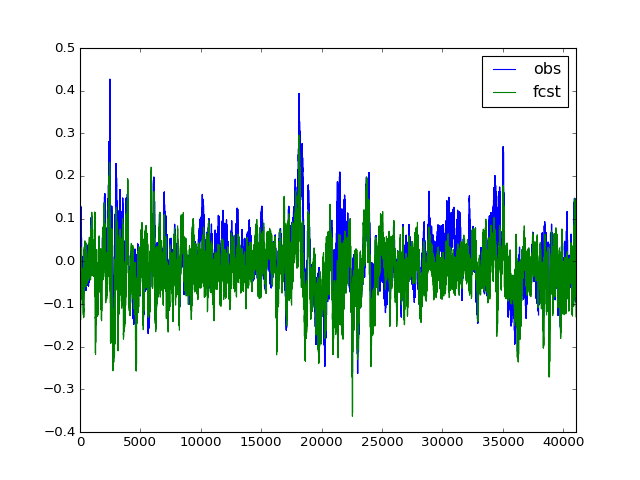

In [390]:
check[['obs','fcst']].plot()